<a href="https://colab.research.google.com/github/Yang-yamper/practice-for-graduation/blob/main/grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)

tensorflow version:  2.8.2
keras version:  2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def grad_cam(input_model, x, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image


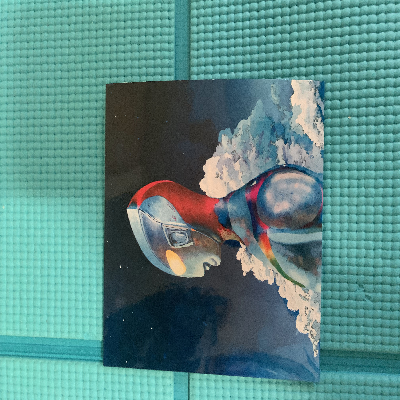

In [ ]:
IMAGE_SIZE=(400,400)
model_path = '/content/drive/My Drive/tea_predict.hdf5/'
image_path = '/content/drive/My Drive/sample_data/M87/IMG_7768.jpg'

model = load_model(model_path)
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))
array_to_img(x)

In [ ]:
target_layer = 'conv2d_7'
cam = grad_cam(model, x, target_layer)

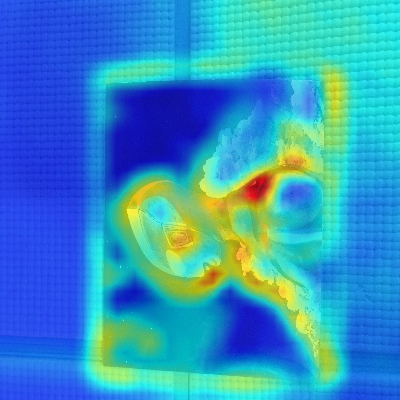

In [ ]:
array_to_img(cam)